# Helix analysis

We look at protein helices with HELANAL.

**Last updated:** December 2022 with MDAnalysis 2.4.0-dev0

**Minimum version of MDAnalysis:** 2.0.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests

**Optional packages for visualisation:**

* [matplotlib](https://matplotlib.org)
* [nglview](http://nglviewer.org/nglview/latest/)

Throughout this tutorial we will include cells for visualising Universes with the [NGLView](http://nglviewer.org/nglview/latest/api.html) library. However, these will be commented out, and we will show the expected images generated instead of the interactive widgets.

<div class="alert alert-info">
    
**Note**

`MDAnalysis.analysis.helix_analysis.HELANAL` implements the HELANAL algorithm from <a data-cite="bansal_helanal_2000" href="https://doi.org/10.1080/07391102.2000.10506570">Bansal *et al.*, 2000</a>, which itself uses the method of <a data-cite="sugeta_general_1967" href="https://doi.org/10.1002/bip.1967.360050708">Sugeta and Miyazawa, 1967</a> to characterise each local axis. Please cite them when using this module in published work.

</div>




In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import helix_analysis as hel
import matplotlib.pyplot as plt
# import nglview as nv
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>)

In [2]:
u = mda.Universe(PSF, DCD)

/Users/lily/pydev/mdanalysis/package/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


## Helix analysis

HELANAL can be used to characterize the geometry of helices with at least 9 residues. The geometry of an alpha helix is characterized by computing local helix axes and local helix origins for four contiguous C-alpha atoms, using the procedure of Sugeta and Miyazawa (<a data-cite="sugeta_general_1967" href="https://doi.org/10.1002/bip.1967.360050708">Sugeta and Miyazawa, 1967</a>) and sliding this window over the length of the helix in steps of one C-alpha atom.

``HELANAL`` computes a number of properties.

<center>
<div style="width: 600px; text-align: center;">

![local properties](helanal_images/local_properties.png)
   
</div>
</center>


For each sliding window, it calculates:

* ``local_rotation_vectors``: the vectors bisecting the angles of the middle 2 atoms
* ``local_origins``: the projected origins of the helix
* ``local_twists``: the twist of each window ($\theta$)
* ``residues_per_turn``: how many residues would fit in a turn, based on ``local_twist``
* ``local_axes``: the axis of each local helix
* ``local_heights``: the rise of each helix

HELANAL calculates the bends between each ``local_axes`` and fits the vector ``global_axes`` to the ``local_origins``.

<center>
<div style="width: 150px; text-align: center;">

![local axes](helanal_images/local_axes_properties.png)
   
</div>
</center>

``all_bends`` contains the angles between every `local_axes` ($\alpha$) in a pairwise matrix, whereas ``local_bends`` contains the angles between ``local_axes`` that are calculated 3 windows apart ($\beta$). The ``global_tilts`` ($\gamma$) are calculated as the angle between the ``global_axes`` and the user-given reference ``ref_axis``.

<center>
<div style="width: 200px; text-align: center;">

![screw angles](helanal_images/screw_angles.png)
   
</div>
</center>

Finally, ``local_screw`` angles are computed between the ``local_rotation_vectors`` and the normal plane of the ``global_axes``.

### Running the analysis

As with most other analysis classes in MDAnalysis, pass in the universe and selection that you would to like to operate on. The default reference axis is the z-axis. You can also pass in a list of selection strings to run HELANAL on multiple helices at once.

In [3]:
h = hel.HELANAL(u, select='name CA and resnum 161-187',
                ref_axis=[0, 0, 1]).run()

The properties described above are stored as attributes in `h.results`. For example, the ``all_bends`` matrix contains the bends in a `(n_frames, n_residues-3, n_residues-3)` array.

In [4]:
h.results.all_bends.shape

(98, 24, 24)

Each property is also summarised with a mean value, the sample standard deviation, and the average deviation from the mean.

In [5]:
h.results.summary.keys()

dict_keys(['local_twists', 'local_bends', 'local_heights', 'local_nres_per_turn', 'local_origins', 'local_axes', 'local_helix_directions', 'local_screw_angles', 'global_axis', 'global_tilts', 'all_bends'])

In [6]:
for key, val in h.results.summary['global_tilts'].items():
    print(f"{key}: {val:.3f}")

mean: 86.121
sample_sd: 2.011
abs_dev: 1.715


As the data is stored as arrays, it can easily be plotted.

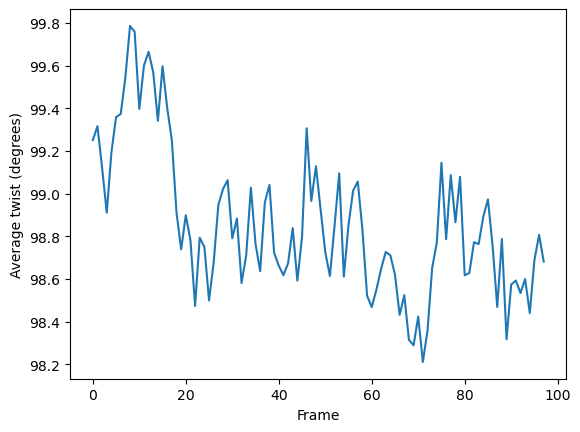

In [7]:
plt.plot(h.results.local_twists.mean(axis=1))
plt.xlabel('Frame')
plt.ylabel('Average twist (degrees)');

You can also create a Universe from the ``local_origins`` if you would like to save it as a file and visualise it in programs such as VMD.

In [8]:
origins = h.universe_from_origins()

In [9]:
# view = nv.show_mdanalysis(h.atomgroups[0])
# view.add_trajectory(origins)
# view

Below we use NGLView to create a representative GIF.

In [10]:
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(
#     view,
#     step=4,  # keep every 4th step
#     render_params={"factor": 3},  # controls quality
#     output='helanal_images/helanal-view.gif',
# )
# movie.make()

<center>
<div style='width: 800px'>
    
![helanal gif](helanal_images/helanal-view.gif)
    
</div>
</center>

## References

[1] M.&nbsp;Bansal, S.&nbsp;Kumar, and R.&nbsp;Velavan.
<span class="bibtex-protected">HELANAL</span>: a program to characterize helix geometry in proteins.
<em>Journal of Biomolecular Structure &amp; Dynamics</em>, 17(5):811–819, April 2000.
00175.
<a href="https://doi.org/10.1080/07391102.2000.10506570">doi:10.1080/07391102.2000.10506570</a>.

[2] Oliver Beckstein, Elizabeth&nbsp;J. Denning, Juan&nbsp;R. Perilla, and Thomas&nbsp;B. Woolf.
Zipping and <span class="bibtex-protected">Unzipping</span> of <span class="bibtex-protected">Adenylate</span> <span class="bibtex-protected">Kinase</span>: <span class="bibtex-protected">Atomistic</span> <span class="bibtex-protected">Insights</span> into the <span class="bibtex-protected">Ensemble</span> of <span class="bibtex-protected">Open</span>↔<span class="bibtex-protected">Closed</span> <span class="bibtex-protected">Transitions</span>.
<em>Journal of Molecular Biology</em>, 394(1):160–176, November 2009.
00107.
URL: <a href="https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164">https://linkinghub.elsevier.com/retrieve/pii/S0022283609011164</a>, <a href="https://doi.org/10.1016/j.jmb.2009.09.009">doi:10.1016/j.jmb.2009.09.009</a>.

[3] Richard&nbsp;J. Gowers, Max Linke, Jonathan Barnoud, Tyler J.&nbsp;E. Reddy, Manuel&nbsp;N. Melo, Sean&nbsp;L. Seyler, Jan Domański, David&nbsp;L. Dotson, Sébastien Buchoux, Ian&nbsp;M. Kenney, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> <span class="bibtex-protected">Python</span> <span class="bibtex-protected">Package</span> for the <span class="bibtex-protected">Rapid</span> <span class="bibtex-protected">Analysis</span> of <span class="bibtex-protected">Molecular</span> <span class="bibtex-protected">Dynamics</span> <span class="bibtex-protected">Simulations</span>.
<em>Proceedings of the 15th Python in Science Conference</em>, pages 98–105, 2016.
00152.
URL: <a href="https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html">https://conference.scipy.org/proceedings/scipy2016/oliver_beckstein.html</a>, <a href="https://doi.org/10.25080/Majora-629e541a-00e">doi:10.25080/Majora-629e541a-00e</a>.

[4] Naveen Michaud-Agrawal, Elizabeth&nbsp;J. Denning, Thomas&nbsp;B. Woolf, and Oliver Beckstein.
<span class="bibtex-protected">MDAnalysis</span>: <span class="bibtex-protected">A</span> toolkit for the analysis of molecular dynamics simulations.
<em>Journal of Computational Chemistry</em>, 32(10):2319–2327, July 2011.
00778.
URL: <a href="http://doi.wiley.com/10.1002/jcc.21787">http://doi.wiley.com/10.1002/jcc.21787</a>, <a href="https://doi.org/10.1002/jcc.21787">doi:10.1002/jcc.21787</a>.